In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV # for cross-validation
import numpy as np
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, make_scorer
from scipy.stats.mstats import winsorize
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
df_train_in = pd.read_csv("https://edouardpauwels.fr/MLM2DSSS/challenge_train_features.csv",index_col=0)
y_train = pd.read_csv("https://edouardpauwels.fr/MLM2DSSS/challenge_train_revenue.csv",index_col=0)
df_test = pd.read_csv("https://edouardpauwels.fr/MLM2DSSS/challenge_test_features.csv",index_col=0)

In [3]:
df_train_in.head()

,title,language,country,length,date,genre,summary,collection,company,webpage,poster_file,cast,keywords,crew,popularity_score,budget
0,Rocky V,en,US,104.0,10/18/90,Drama,A lifetime of taking shots has ended Rocky's c...,Rocky Collection,United Artists,NaN,G6shAlq8wwud6byWm13tLuiR2P5.jpg,"Sylvester Stallone,Talia Shire,Burt Young,Sage...","philadelphia,transporter,father son relationsh...","[{'job': 'Director', 'name': 'John G. Avildsen...",14.007329,42000000
1,Oculus,en,US,104.0,9/8/13,Horror,A woman tries to exonerate her brother's murde...,NaN,"Intrepid Pictures,Blumhouse Productions,Relati...",NaN,HcPqD6LzKOPqXkLocfSly49C8ci.jpg,"Karen Gillan,Brenton Thwaites,Katee Sackhoff,J...","hallucination,supernatural,mirror,skepticism,g...","[{'job': 'Casting', 'name': 'Anne McCarthy'}, ...",8.698043,5000000
2,Tomorrowland,en,US,130.0,5/19/15,"Adventure,Family,Mystery,Science Fiction","Bound by a shared destiny, a bright, optimisti...",NaN,"Walt Disney Pictures,Babieka,A113",http://movies.disney.com/tomorrowland,MTBS6htgG0g2EUf93yZQNV9zC96.jpg,"Britt Robertson,George Clooney,Raffey Cassidy,...","inventor,apocalypse,destiny,imax,dreamer,futur...","[{'job': 'Editor', 'name': 'Craig Wood'}, {'jo...",22.296076,190000000
3,Things Are Tough All Over,en,US,90.0,8/4/82,"Action,Comedy",Cheech and Chong are hired to drive a limo fro...,Cheech & Chong Collection,C & C Brown Production,NaN,vxdj0agTm8reLtxXuzQVkYYx7oA.jpg,"Cheech Marin,Tommy Chong,Toni Attell,Mike Baca...","pornography,chicago,money laundering,gas stati...","[{'job': 'Writer', 'name': 'Cheech Marin'}, {'...",9.442756,0
4,How to Be Single,en,US,110.0,1/21/16,"Comedy,Romance",New York City is full of lonely hearts seeking...,NaN,"New Line Cinema,Flower Films,Metro-Goldwyn-May...",http://howtobesinglemovie.com/,O8UMYar5eX8iYY5c8qTKO4rFhAj.jpg,"Dakota Johnson,Rebel Wilson,Alison Brie,Nichol...","new york,based on novel,one-night stand,single","[{'job': 'Casting', 'name': 'Avy Kaufman'}, {'...",8.898988,38000000


In [3]:
def replace_na(df, col):
    median_value = df[col].median()
    df[col] = df[col].clip(lower=0)
    df[col] = df[col].fillna(0)        
    df[col] = df[col].replace(0, median_value)    
    return df[col]

In [4]:
def compute_outliers(df, col):
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return lower, upper

def winsorize_df(df, col):
    lim_inf, lim_sup = compute_outliers(df, col)
    series_w = df[col].copy()
    series_w = series_w.clip(lower=lim_inf, upper=lim_sup)    
    return series_w

In [5]:
def scale_features(train, test, cols):
    train_scaled = train.copy()
    test_scaled = test.copy()

    for col in cols:
        scaler = StandardScaler()
        # Fit en train, transform en ambos
        train_scaled[col] = scaler.fit_transform(train[[col]])
        test_scaled[col] = scaler.transform(test[[col]])

    return train_scaled, test_scaled

In [6]:
def rescaling_features (df):
    df['log_popularity_score'] = np.log(2+df['popularity_score'])
    #df['log_popularity_score'].replace(-np.inf, min(df['log_popularity_score'])) #Por si log(1+(-1))
    df['length_2'] = df['length'] ** 2
    df['length_3'] = (2+df['length']) ** 3
    df['popularity_score_2'] = df['popularity_score'] ** 2
    df['popularity_score_3'] = (2+df['popularity_score']) ** 3
    df['budget_2'] = df['budget'] ** 2
    df['budget_3'] = (2+df['budget']) ** 3
    df['budget_4'] = (df['budget']) ** 4
    df['log_budget'] = np.log1p(df['budget'])
    return(df)

In [7]:
def clean_dummies (df):
  x_dum = df.copy()
  #Date
  date_split = df["date"].str.split("/", expand=True)
  x_dum["month"] = date_split[0].astype(int)
  x_dum["day"] = date_split[1].astype(int)
  x_dum["year"] = date_split[2].astype(int)
  x_dum["year"] = np.where(x_dum["year"] > 27, 1900 + x_dum["year"], 2000 + x_dum["year"])
  # Sequels ======================================================================
  x_dum["sequels"] = df["collection"].apply(lambda c: 0 if pd.isna(c) else 1)
  # Marketing ======================================================================
  x_dum["marketing"] = df["webpage"].apply(lambda c: 0 if pd.isna(c) else 1)
  # English ======================================================================
  x_dum["english"] = df["language"].apply(lambda c: 0 if c=="en" else 1)
  # Big company (only Top 10) =====================================================
  big_companies = ["Twentieth Century Fox Film Corporation", "Universal Pictures", "Warner Bros. Pictures",
                   "Columbia Pictures Corporation", "Walt Disney Pictures", "Marvel Studios", "Paramount Pictures",
                   "Legendary Pictures", "New Line Cinema", "DreamWorks Animation"]
  x_dum["big_comp"] = df["company"].apply(
      lambda company: 1 if isinstance(company, str) and any(company in big_companies for company in company.split(",")) else 0
  )
  return x_dum


In [8]:
def check_invalid_log(df: pd.DataFrame, col: str) -> pd.DataFrame:
    if col not in df.columns:
        raise ValueError(f"Columna {col} no encontrada en el DataFrame.")
    mask_invalid = ~np.isfinite(np.log(2+df[col]))
    invalid_rows = df.loc[mask_invalid]
    print(f"Filas con valores inválidos para log en {col}: {len(invalid_rows)}")
    return invalid_rows

In [19]:
df_train_in = pd.read_csv("https://edouardpauwels.fr/MLM2DSSS/challenge_train_features.csv",index_col=0)
y_train = pd.read_csv("https://edouardpauwels.fr/MLM2DSSS/challenge_train_revenue.csv",index_col=0)
df_test = pd.read_csv("https://edouardpauwels.fr/MLM2DSSS/challenge_test_features.csv",index_col=0)
for col in ["budget", "length", "popularity_score"]:
    df_train_in[col] = replace_na(df_train_in, col)
    df_train_in[col] = winsorize_df(df_train_in, col)
    df_test[col] = replace_na(df_test, col)
    df_test[col] = winsorize_df(df_test, col)
#Rescaling
df_train_in = rescaling_features(df_train_in)
df_test = rescaling_features(df_test)
#Get dummies
df_train_in_run = clean_dummies(df_train_in)
df_test_run = clean_dummies(df_test)
#Choose variables
features = ["sequels", "big_comp", "budget", "budget_3", "length",
            "log_popularity_score", "year", "month"]
df_train_run = df_train_in_run[features]
df_test_run = df_test_run[features]

In [13]:
#Separate train, test
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
X_tr, X_val, y_tr, y_val = train_test_split(df_train_run, y_train, test_size=0.2, random_state=42)

#Notes for the xgboots model:
#50000, 0.0001, 7, 128, 0.8,0.8,0.5,2.0,5 (con budget_3, con year y month sin day, marketing, english) :: 1.729048 
#y sin y_tr (y normal sin log) ni separación train test
#50000,0.0001, 7 (con budget_3, con year y month sin day, marketing, english) :: 1.736774 y sin y_tr ni separación train test
#14000,0.0005, 7 (con budget_3, con year, sin: month y day, marketing, english) :: 1.743251 y sin y_tr ni separación train test
#7500, 0.001, 3 (con budget_3, sin: year, month y day, marketing, english) :: 1.785824 y sin y_tr ni separación train test
#6000, 0.001, 3 (sin budget_3, sin year, month y day, marketing, english) y sin y_tr ni separación train test

In [49]:
########################################################################
# Modelo 1 XGBRegressor() - Best: 1.729048 
########################################################################
#Top modelo por ahora
xgb = XGBRegressor(
    n_estimators=50000,         # ← CAMBIO: 50k → 1500 (30s vs 2h)
    learning_rate=0.0001,        # ← CAMBIO: 0.0001 → 0.05 (Producto=75)
    max_depth=7,               # ← CAMBIO: 7 → 6 (más capacidad)
    max_leaves=128,             # ← CAMBIO: 128 → 64 (correcto 2^6)
    random_state=42,
    subsample=0.8,             # ← 0.8 → 0.9 (más datos = mejor)
    colsample_bytree=0.8,      # ← 0.8 → 0.9 (más features = mejor)
    reg_alpha=0.5,             # ← 0.5 → 0.1 (menos L1 = más flexible)
    reg_lambda=2.0,            # ← 2.0 → 0.5 (menos L2 = más preciso)
    min_child_weight=5,        # ← 5 → 1 (hojas más pequeñas = mejor fit)
)

#Train error
xgb.fit(X_tr, y_tr)
y2 = xgb.predict(X_val)
y2 = np.maximum(y2,0)
msle2 = mean_squared_log_error(y_val, y2)
print(f"Train MSLE: {msle2:.6f}")

#Test set
xgb.fit(df_train_run, y_train)
y_output = xgb.predict(df_test_run)
strRes = [str(s) for s in np.round(y_output, 0)]
predStr = reduce(lambda x, y: x + ', ' + y, strRes)
print(predStr)

Train MSLE: 7.012799
1.0790977e+08, 9.890312e+06, 2.1101382e+07, 3.1412266e+07, 9.839384e+06, 1.3761774e+08, 1.9952906e+08, 5.794834e+07, 7.094499e+06, 6.6919676e+07, 1.702692e+08, 6.070075e+06, 7.4110696e+07, 1.8509398e+08, 6.966606e+06, 2.8911898e+07, 1.3789074e+07, 1.1461682e+07, 3.2497616e+07, 2.5119954e+07, 2.9058124e+07, 7.232515e+07, 4.801133e+07, 1.0178742e+07, 9.946225e+06, 4.681687e+06, 1.0333492e+07, 2.5342112e+07, 6.564277e+06, 2.994405e+06, 7.9400296e+07, 3.1576286e+07, 2.1078864e+07, 3.1942872e+07, 2.0648516e+07, 1.4365422e+08, 3.906234e+07, 1.0907855e+07, 4.00035e+07, 1.616756e+06, 8.928893e+07, 6.2065084e+07, 4.0183412e+07, 2.3865506e+08, 5.4623704e+07, 2.4313216e+07, 1.4982437e+07, 1.2797698e+07, 5.225835e+07, 7.6074824e+07, 2.3693317e+08, 4.2329944e+07, 3.688327e+08, 7.781624e+06, 2.1094344e+07, 3.942083e+07, 1.0583884e+07, 2.1081883e+08, 3.845893e+08, 2.6829826e+07, 1.9896768e+07, 8.726091e+06, 1.9832776e+07, 8.147158e+07, 1.1377704e+07, 5.72134e+06, 5.814733e+06, 1.

In [46]:
########################################################################
# Modelo 2 RandomForestRegressor() - Best: 1.696948
########################################################################
from sklearn.model_selection import RandomizedSearchCV

#Grid search
param_grid = {
    'n_estimators': [200]}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=0, n_jobs=-1),
    param_distributions=param_grid,
    scoring='neg_mean_squared_log_error',
    n_iter=25,
    cv=5,
    random_state=0,
    n_jobs=-1
)

#Train
y_log = np.log1p(y_train)
search.fit(df_train_run, y_train.values.ravel())
y_pred_test = search.predict(df_test_run)
print("Mejores parámetros:", search.best_params_)
strRes = [str(s) for s in np.round(y_pred_test, 0)]
predStr = reduce(lambda x, y: x + ', ' + y, strRes)
print(predStr)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=25. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores parámetros: {'n_estimators': 200}
138225590.0, 14971406.0, 17429275.0, 46404926.0, 8705080.0, 103810487.0, 171660345.0, 52067543.0, 10568437.0, 58536341.0, 181308753.0, 5533953.0, 82709931.0, 214372189.0, 5240707.0, 35215547.0, 8162877.0, 7378909.0, 33335009.0, 19702147.0, 27650284.0, 90893170.0, 39568641.0, 3871517.0, 10974708.0, 5727677.0, 9687504.0, 27669985.0, 1193218.0, 337451.0, 109894119.0, 36366825.0, 18263752.0, 24303513.0, 34806055.0, 108721033.0, 17204083.0, 5394133.0, 37164296.0, 859899.0, 51938869.0, 41413379.0, 41583824.0, 203737004.0, 76211815.0, 21997195.0, 8113634.0, 11724204.0, 61998119.0, 83418056.0, 193776373.0, 35781085.0, 397389978.0, 11241014.0, 28382308.0, 40400139.0, 2030346.0, 256101417.0, 341388905.0, 10080483.0, 42990231.0, 8320814.0, 13766374.0, 95853652.0, 14479172.0, 8358934.0, 4053224.0, 8339030.0, 77157319.0, 340324303.0, 24342782.0, 7426171.0, 877819.0, 1101098.0, 22642835.0, 2000296.0, 70850419.0, 8084428.0, 36665776.0, 76605820.0, 7258748.0, 

In [25]:
#Now we need to scale for clustering
num_cols = df_train_valid.select_dtypes(include=np.number).columns.tolist() #Names of columns that are numeric
cols_to_scale = [c for c in num_cols if c not in ['year', 'month']] #Columns to scale except year and month

df_train_scaled, df_test_scaled = scale_features(df_train_run, df_test_run, cols_to_scale) #Scale them

#First we do clustering in three groups: Top films, Medium films and "Probably unpopular films"
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
train_clusters = kmeans.fit_predict(df_train_scaled[num_cols]) #Train clusters on training set
test_clusters = kmeans.predict(df_test_scaled[num_cols]) #Predict clusters in test set
#Agregar grafico para los clusters?

#Second we train Random forest in each cluster
cluster_models = {} #Where we will save the models for each cluster
for cluster in range(n_clusters):
    #For each cluster we select the corresponding lines in the training set
    mask = train_clusters == cluster
    X_cluster = df_train_scaled.iloc[mask] #Select in X
    y_cluster = np.log1p(y_train_valid[mask]) #We transform to logs for better prediction power
    
    model = RandomForestRegressor(
        n_estimators=400,
        max_depth=15,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=0,
        n_jobs=-1
    ) #Initialize the model
    model.fit(X_cluster[num_cols], y_cluster) #train the model
    cluster_models[cluster] = model #Save the model

#Predict for test set
y_pred_log = np.zeros(df_test_scaled.shape[0]) #Initialize predictions to 0
for cluster in range(n_clusters):
    #For each cluster we select the corresponding lines in the test set
    mask = test_clusters == cluster
    X_cluster_test = df_test_scaled.iloc[mask] #Select in X
    y_pred_log[mask] = cluster_models[cluster].predict(X_cluster_test[num_cols])
    #We predict for each model from each cluster the y labels

# Revertir log
y_pred = np.expm1(y_pred_log) #We predicted logs and we need levels so exponential transformation
strRes = [str(s) for s in np.round(y_pred, 0)]
predStr = reduce(lambda x, y: x + ', ' + y, strRes)
print(predStr)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


98600858.0, 6140400.0, 2656040.0, 8882629.0, 1550422.0, 112080767.0, 19326150.0, 38075569.0, 2516016.0, 64019701.0, 57118864.0, 999654.0, 44649620.0, 8174391.0, 1155691.0, 8559094.0, 2499173.0, 3182056.0, 2860334.0, 7380370.0, 15350288.0, 60360544.0, 13551076.0, 103974.0, 11331668.0, 627168.0, 2110114.0, 5267922.0, 447090.0, 63175.0, 62319392.0, 25648084.0, 5149682.0, 28254237.0, 2496365.0, 120702714.0, 6640345.0, 2647852.0, 21050765.0, 778010.0, 9954585.0, 26222359.0, 31026521.0, 174042258.0, 44223300.0, 6785809.0, 2903205.0, 1060893.0, 14260491.0, 28601306.0, 176412695.0, 28988845.0, 323408788.0, 7445847.0, 5808092.0, 18504891.0, 761006.0, 55943399.0, 207901648.0, 5578875.0, 5063543.0, 4147949.0, 8508380.0, 58796847.0, 12029852.0, 1119667.0, 1394611.0, 2254638.0, 60346891.0, 230287763.0, 16661600.0, 2553377.0, 53839.0, 66021.0, 4314019.0, 347593.0, 61417925.0, 1605198.0, 14040270.0, 17753074.0, 1360204.0, 10691550.0, 55701740.0, 876132.0, 4036448.0, 17718852.0, 24247487.0, 42845000.0


Número de características: 11
Número de importancias: 11

Feature Importances:
                 Feature  Importance
2                 budget    0.262940
5   log_popularity_score    0.136660
1               big_comp    0.093279
0                sequels    0.089437
10               english    0.071407
6                   year    0.070242
3               budget_3    0.068183
4                 length    0.055754
9              marketing    0.054522
8                    day    0.049045
7                  month    0.048531


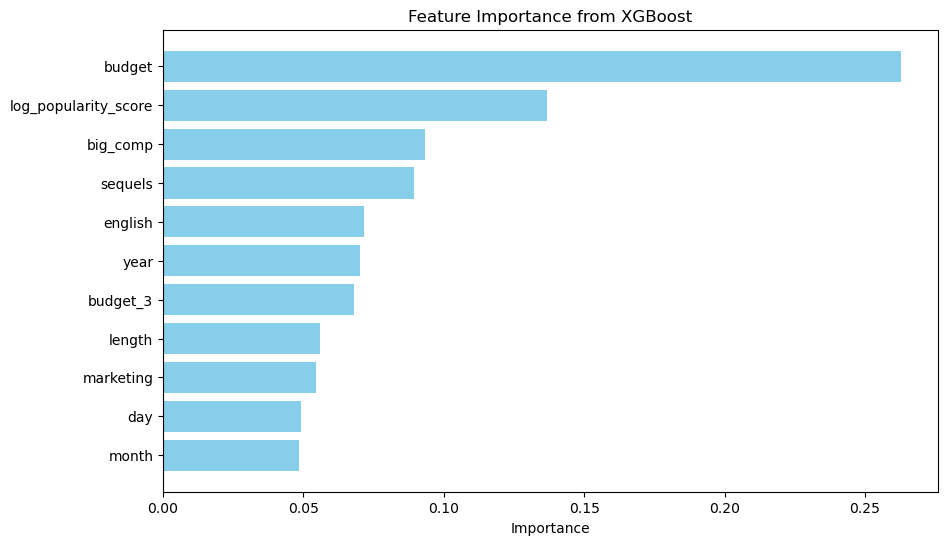

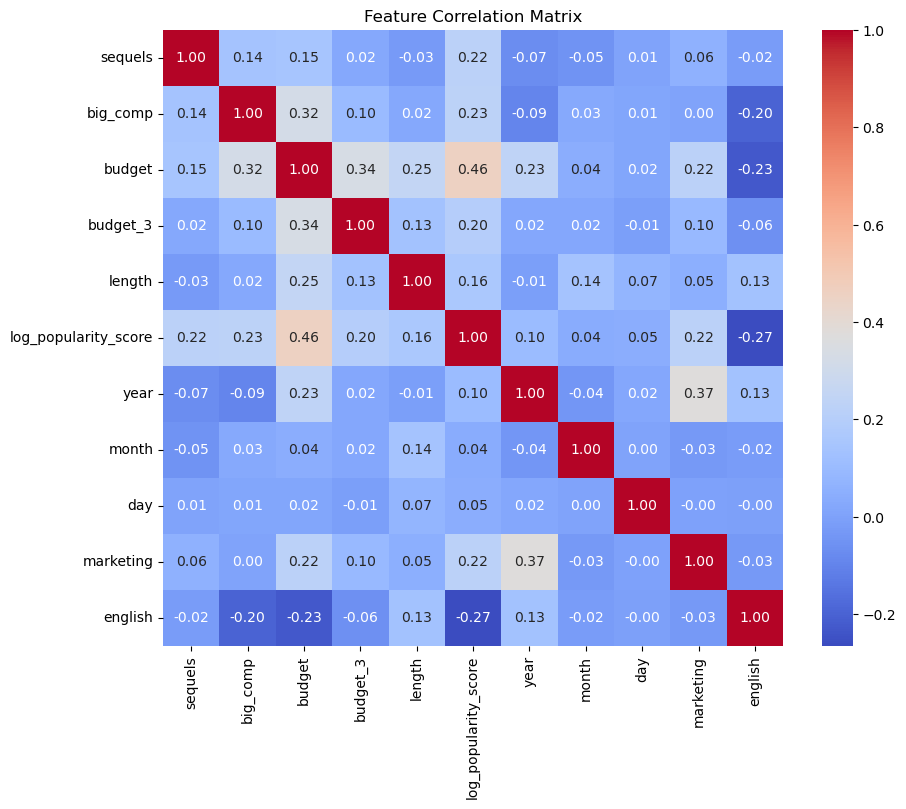


Features to prune (importance < 0.01): []


In [77]:
import matplotlib.pyplot as plt

# Importancias
importances = xgb.feature_importances_

# Verificar longitudes
print(f"\nNúmero de características: {len(features)}")
print(f"Número de importancias: {len(importances)}")

# Asegurar que coincidan
if len(features) != len(importances):
    print("Error: Longitudes no coinciden. Ajustando features...")
    features = [f"feature_{i}" for i in range(len(importances))]

# Crear DataFrame de importancias
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)

# Visualizar importancias
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()

# Matriz de correlación (usando df_train_run)
correlation_matrix = df_train_run.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# Identificar características redundantes
low_importance_threshold = 0.01
redundant_features = feature_importance_df[feature_importance_df['Importance'] < low_importance_threshold]['Feature']
print("\nFeatures to prune (importance < 0.01):", redundant_features.tolist())

In [102]:
xgb.fit(df_train_run, y_train)

y_output = xgb.predict(df_test_run)
# Redondear la unidad mas cercana
strRes = [str(s) for s in np.round(y_output, 0)]

#Poner en forma del vector del profesor
predStr = reduce(lambda x, y: x + ', ' + y, strRes)

print(predStr)

124012280.0, 9197711.0, 22620376.0, 29942836.0, 10433732.0, 139044030.0, 206568200.0, 62908972.0, 6981361.0, 70962020.0, 182200450.0, 8928326.0, 87750500.0, 161028500.0, 11745923.0, 27800236.0, 13980102.0, 10924849.0, 30474598.0, 24527794.0, 28110452.0, 64777748.0, 63031456.0, 9491594.0, 11311508.0, 4404491.0, 10621842.0, 31627176.0, 8324688.0, 1862864.0, 75281896.0, 31697048.0, 21086130.0, 34802990.0, 24734928.0, 153875900.0, 33157788.0, 9743802.0, 40914904.0, 1973550.0, 65125228.0, 85528660.0, 39099264.0, 277648860.0, 60484956.0, 22507932.0, 16548621.0, 11773123.0, 48173576.0, 94092216.0, 217371150.0, 45993324.0, 364868320.0, 7973247.0, 22392674.0, 39006640.0, 14185709.0, 158824720.0, 295910880.0, 30947178.0, 19254908.0, 11808094.0, 19890240.0, 95942810.0, 13071538.0, 5159430.0, 4911424.0, 13753982.0, 58139996.0, 464639100.0, 28663598.0, 9041545.0, 1223173.0, 2352383.0, 25076372.0, 5752095.0, 86303060.0, 10423701.0, 28207216.0, 56753220.0, 7052512.0, 22298376.0, 84593190.0, 79044460.

In [ ]:
"""
#Correcto
xgb.fit(X_tr, y_tr)

y_output = xgb.predict(X_val)

#xgb.fit(df_train_run, y_train.values.ravel())

y_output = xgb.predict(X_val)
y_output = np.maximum(y_output, 0)  # ← Solo valores ≥ 0
msle = mean_squared_log_error(y_val, y_output)
print(f"🏆 TU MSLE: {msle:.6f}")
"""

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# 🔥 TUS RESULTADOS (agrega más aquí)
data = [
    {'n_estimators': 5000, 'learning_rate': 0.01, 'max_depth': 5, 'msle': 1.785824, 'name': 'Actual'},
    {'n_estimators': 14000, 'learning_rate': 0.0005, 'max_depth': 7, 'msle': 1.743251, 'name': 'Mejor1'},
    {'n_estimators': 50000, 'learning_rate': 0.0001, 'max_depth': 7, 'msle': 1.729048, 'name': 'MEJOR'},
]

df = pd.DataFrame(data)

# 🎯 GRÁFICO 3D INTERACTIVO
fig = go.Figure(data=[go.Scatter3d(
    x=df['n_estimators'],
    y=df['learning_rate'],
    z=df['max_depth'],
    mode='markers+text',
    marker=dict(
        size=12,
        color=df['msle'],  # 🎨 Color por MSLE (rojo=peor, azul=mejor)
        colorscale='Viridis', 
        showscale=True,
        colorbar=dict(title="MSLE")
    ),
    text=df['name'] + f"<br>MSLE: {df['msle']:.3f}",  # Tooltip
    textposition="middle center",
    hovertemplate='<b>%{text}</b><extra></extra>'
)])

# 📐 CONFIGURACIÓN
fig.update_layout(
    title={
        'text': '🎯 3D: MSLE vs n_estimators + learning_rate + max_depth',
        'x': 0.5, 'font': {'size': 20}
    },
    scene=dict(
        xaxis_title='n_estimators',
        yaxis_title='learning_rate (log)',
        zaxis_title='max_depth',
        yaxis_type='log'
    ),
    width=900,
    height=600,
    margin=dict(l=0, r=0, t=50, b=0)
)

# 🚀 MUESTRA
fig.show()

In [30]:
y_output = xgb.predict(df_test_run)
# Redondear la unidad mas cercana
strRes = [str(s) for s in np.round(y_output, 0)]

#Poner en forma del vector del profesor
predStr = reduce(lambda x, y: x + ', ' + y, strRes)

print(predStr)

Note: you may need to restart the kernel to use updated packages.


In [46]:
from sklearn.metrics import mean_squared_log_error
# Configurar GridSearchCV con GradientBoostingRegressor
print("Configurando GridSearchCV")
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [300, 500, 700],           # Centrado en valores altos, cerca de 500
    'learning_rate': [0.005, 0.01, 0.02],      # Tasas bajas para aprendizaje más estable
    'max_depth': [4, 5, 6],                    # Centrado en profundidad 5
    'min_samples_split': [8, 10, 12],          # Cerca de 10
    'min_samples_leaf': [3, 4, 5],             # Cerca de 4
    'subsample': [0.5, 0.6, 0.7],             # Cerca de 0.6
    'max_features': ['sqrt', 'log2', None]     # Corregido, sin 'auto'
}
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,  # Validación cruzada de 5 pliegues
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=1
)
# Entrenar el modelo
print("Entrenando GridSearchCV")
grid_search.fit(df_train_run, y_train.values.ravel())

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor score (neg MSE):", grid_search.best_score_)

# Usar el mejor modelo para predecir
best_model = grid_search.best_estimator_

Configurando GridSearchCV
Entrenando GridSearchCV
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


KeyboardInterrupt: 

In [ ]:
gbr = GradientBoostingRegressor()

# Inicializar el modelo GradientBoostingRegressor
gbr = GradientBoostingRegressor(
    n_estimators=800,  # Número de árboles
    learning_rate=0.05, # Velocidad de aprendizaje
    max_depth=3,       # Profundidad máxima de cada árbol
    random_state=42
)

# Entrenar el modelo
gbr.fit(df_train_run, y_train.values.ravel())

# Hacer predicciones
y_output = gbr.predict(df_test_run)

In [45]:
y_output = best_model.predict(df_test_run)
# Redondear la unidad mas cercana
strRes = [str(s) for s in np.round(y_output, 0)]

#Poner en forma del vector del profesor
predStr = reduce(lambda x, y: x + ', ' + y, strRes)

print(predStr)

151807631.0, 11926058.0, 32063360.0, 23589350.0, 10801989.0, 133974328.0, 216603027.0, 55299304.0, 10791009.0, 60098145.0, 189304252.0, 6048929.0, 119247569.0, 126062396.0, 10337415.0, 24387660.0, 18296408.0, 17445263.0, 35033614.0, 22614769.0, 24056336.0, 61432095.0, 45013694.0, 11577740.0, 11454422.0, 6396386.0, 14268616.0, 28044975.0, 5629298.0, 3725775.0, 74469011.0, 32297681.0, 23309196.0, 34298567.0, 21692837.0, 133642594.0, 35841095.0, 10884958.0, 43287078.0, 2763099.0, 92298417.0, 40271031.0, 44644626.0, 244139271.0, 53016334.0, 25182788.0, 13708956.0, 11923597.0, 52266949.0, 74656714.0, 203917854.0, 46688998.0, 511857601.0, 7608081.0, 17221313.0, 38219590.0, 12313687.0, 201209935.0, 335920342.0, 27466790.0, 23636850.0, 15800326.0, 24281058.0, 87563064.0, 13407236.0, 7309080.0, 5848090.0, 16430045.0, 54209865.0, 390834293.0, 27676451.0, 9220528.0, 1024292.0, 3995267.0, 19792817.0, 5610099.0, 86485023.0, 16444900.0, 22713134.0, 47059077.0, 3752728.0, 18845312.0, 73698717.0, 5970

In [33]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Tus features
features = ["sequels", "big_comp", "budget", "budget_2", "budget_3", "log_budget", "length", "length_2",
            "log_popularity_score", "popularity_score_2", "popularity_score_3"]

# Split de train en train y val
X_train, X_val, y_train_split, y_val = train_test_split(df_train_run, y_train, test_size=0.2, random_state=42)

# Listas de hiperparámetros
learning_rates = [0.001, 0.01, 0.1]
n_estimators = [100, 500, 1000]
max_depths = [3, 5, 7]
subsamples = [0.8, 1.0]
colsample_bytrees = [0.8, 1.0]
min_child_weights = [1, 3]
gammas = [0, 0.1]

# Variables para rastrear el mejor
best_score = np.inf
best_params = None
best_model = None
best_importances = None

# Loop sobre combinaciones
for lr in learning_rates:
    for nest in n_estimators:
        for depth in max_depths:
            for subs in subsamples:
                for col in colsample_bytrees:
                    for mcw in min_child_weights:
                        for gam in gammas:
                            print(f"Probando: lr={lr}, n_estimators={nest}, max_depth={depth}, "
                                  f"subsample={subs}, colsample_bytree={col}, min_child_weight={mcw}, gamma={gam}")
                            
                            # Inicializar modelo
                            xgb = XGBRegressor(
                                n_estimators=nest,
                                learning_rate=lr,
                                max_depth=depth,
                                subsample=subs,
                                colsample_bytree=col,
                                min_child_weight=mcw,
                                gamma=gam,
                                random_state=42
                            )
                            
                            # Fit sin early stopping
                            xgb.fit(X_train, y_train_split.values.ravel())
                            
                            # Predicción en val
                            y_pred_val = xgb.predict(X_val)
                            
                            # Asegurar no negativos para MSLE
                            y_val_safe = np.maximum(y_val, 0)
                            y_pred_val_safe = np.maximum(y_pred_val, 0)
                            
                            # Calcular MSLE
                            score = mean_squared_log_error(y_val_safe, y_pred_val_safe)
                            print(f"  MSLE en validación: {score}")
                            
                            # Importancias de features
                            importances = xgb.feature_importances_
                            print("  Importancias de features:")
                            for feat, imp in zip(features, importances):
                                print(f"    {feat}: {imp:.6f}")
                            print("\n")
                            
                            # Actualizar mejor modelo
                            if score < best_score:
                                best_score = score
                                best_params = (lr, nest, depth, subs, col, mcw, gam)
                                best_model = xgb
                                best_importances = importances

# Mostrar mejor combinación
print(f"Mejor combinación: lr={best_params[0]}, n_estimators={best_params[1]}, max_depth={best_params[2]}, "
      f"subsample={best_params[3]}, colsample_bytree={best_params[4]}, min_child_weight={best_params[5]}, "
      f"gamma={best_params[6]}")
print(f"Mejor MSLE: {best_score:.6f}")
print("Importancias del mejor modelo:")
for feat, imp in zip(features, best_importances):
    print(f"  {feat}: {imp:.6f}")

# Predicción final en test
y_output = best_model.predict(df_test_run)
y_output_safe = np.maximum(y_output, 0)
print("Predicción final en test (y_output):", y_output_safe)
# Redondear la unidad mas cercana
strRes = [str(s) for s in np.round(y_output_safe, 0)]

#Poner en forma del vector del profesor
predStr = reduce(lambda x, y: x + ', ' + y, strRes)

print(predStr)

Probando: lr=0.001, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=0.8, min_child_weight=1, gamma=0
  MSLE en validación: 13.450333595275879
  Importancias de features:
    sequels: 0.151438
    big_comp: 0.018477
    budget: 0.414484
    budget_2: 0.137586
    budget_3: 0.101371
    log_budget: 0.176644


Probando: lr=0.001, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=0.8, min_child_weight=1, gamma=0.1
  MSLE en validación: 13.450333595275879
  Importancias de features:
    sequels: 0.151438
    big_comp: 0.018477
    budget: 0.414484
    budget_2: 0.137586
    budget_3: 0.101371
    log_budget: 0.176644


Probando: lr=0.001, n_estimators=100, max_depth=3, subsample=0.8, colsample_bytree=0.8, min_child_weight=3, gamma=0
  MSLE en validación: 13.450331687927246
  Importancias de features:
    sequels: 0.150924
    big_comp: 0.017945
    budget: 0.413085
    budget_2: 0.138647
    budget_3: 0.103349
    log_budget: 0.176050


Probando: lr=0.001, n_esti

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:title: object, language: object, country: object, date: object, genre: object, summary: object, collection: object, company: object, webpage: object, poster_file: object, cast: object, keywords: object, crew: object

In [28]:
# Agrupar por learning_rate y calcular el MSLE promedio
plot_data = results.groupby('learning_rate')['msle'].mean().reset_index()

# Crear gráfico de línea simple
plt.plot(plot_data['learning_rate'], plot_data['msle'], marker='o', color='blue', label='MSLE')
plt.xlabel('Learning Rate (alpha)')
plt.ylabel('MSLE')
plt.title('Learning Rate vs MSLE')
plt.legend()
plt.grid(True)
plt.show()

AttributeError: 'list' object has no attribute 'groupby'

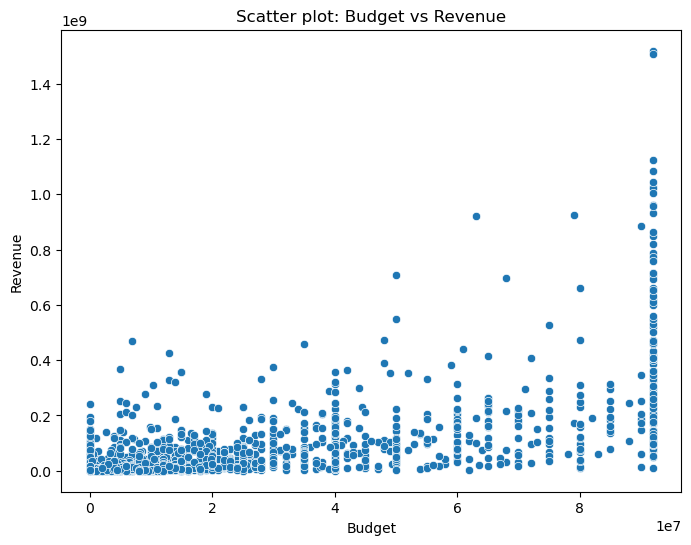

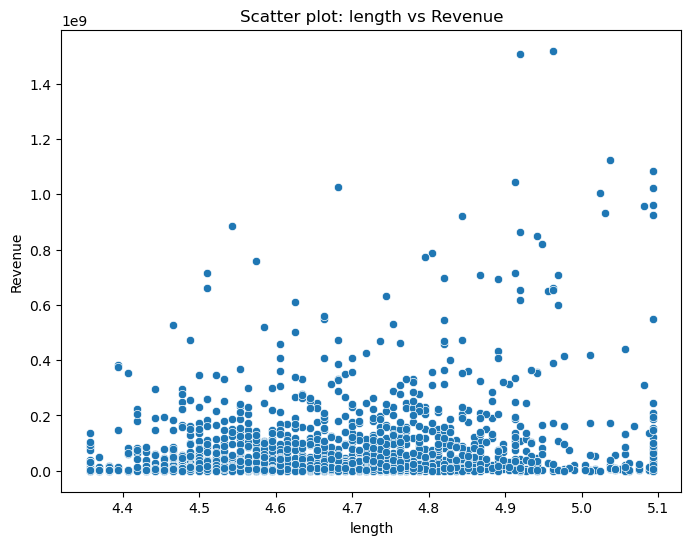

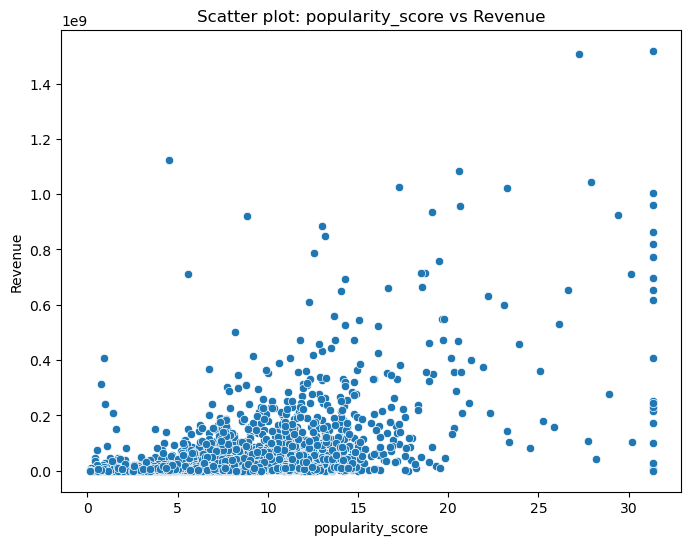

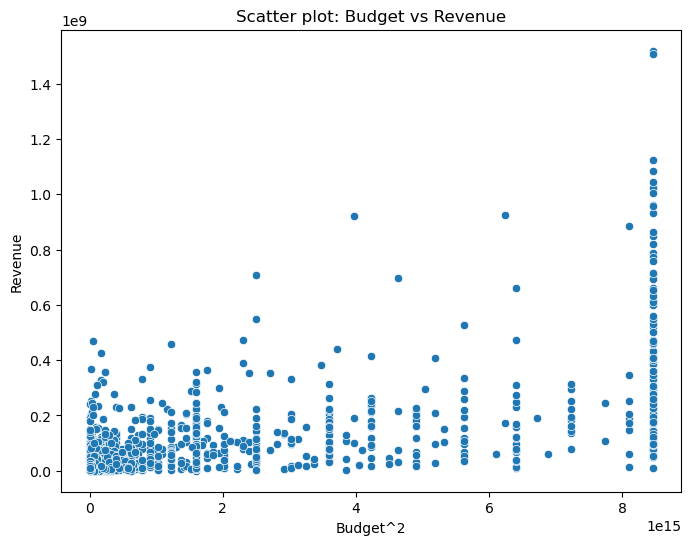

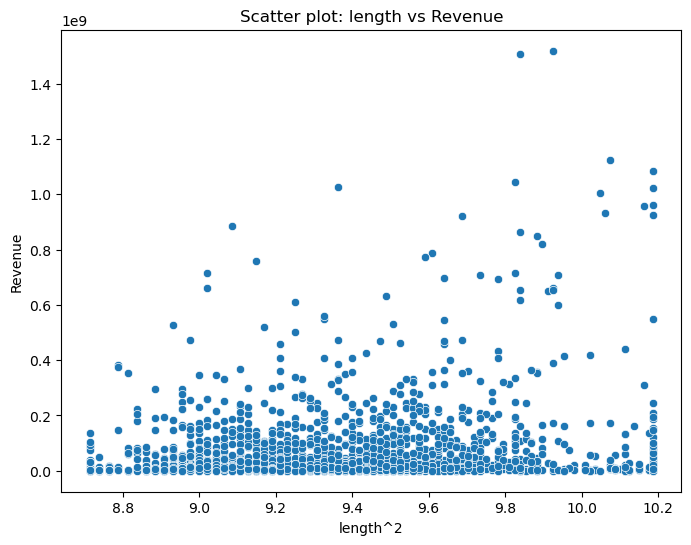

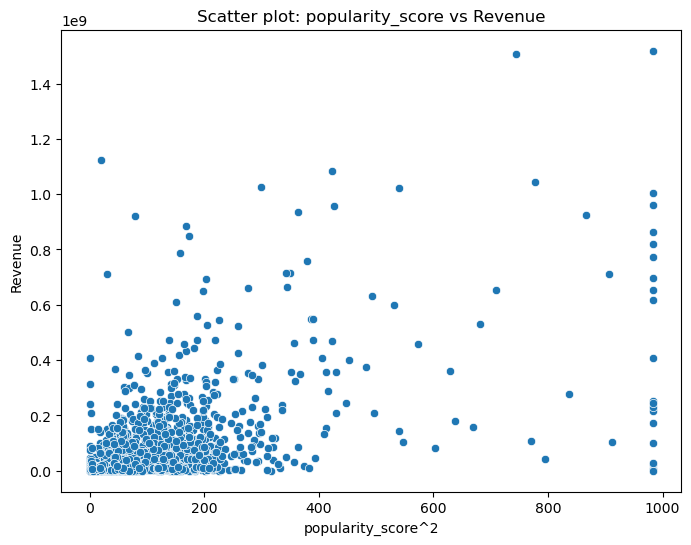

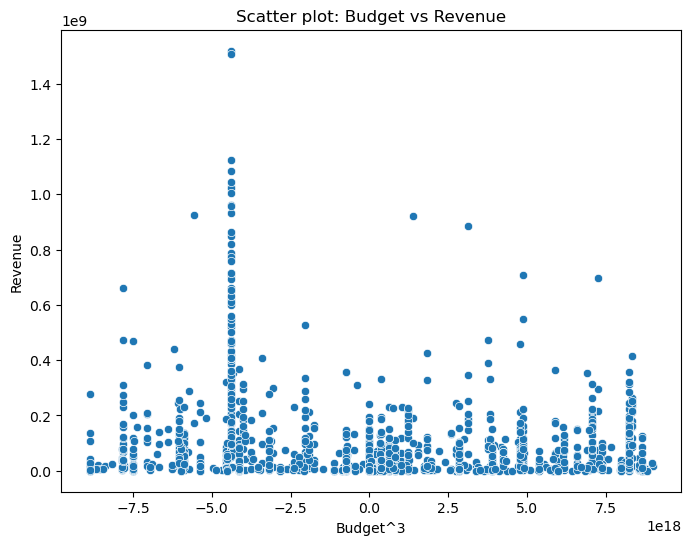

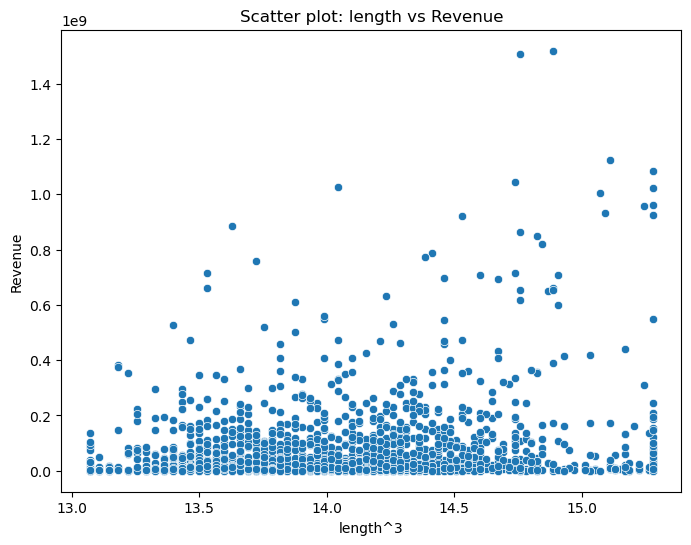

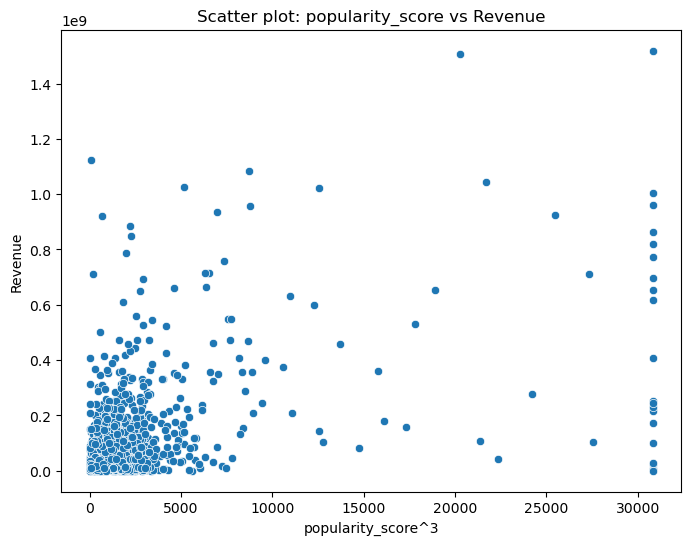

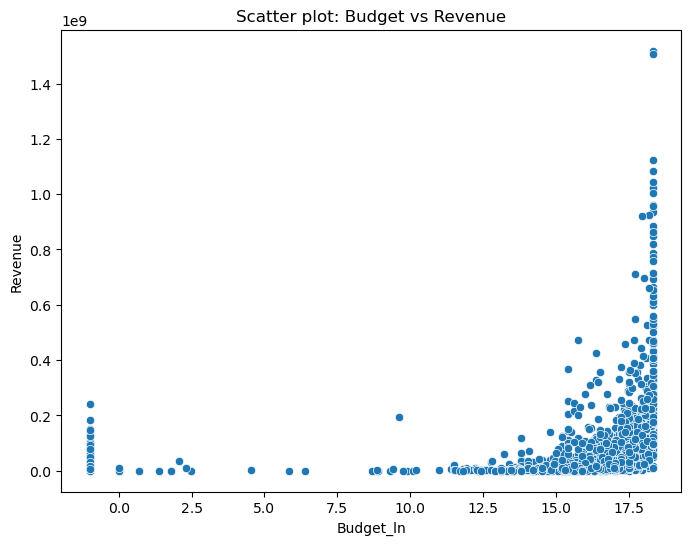

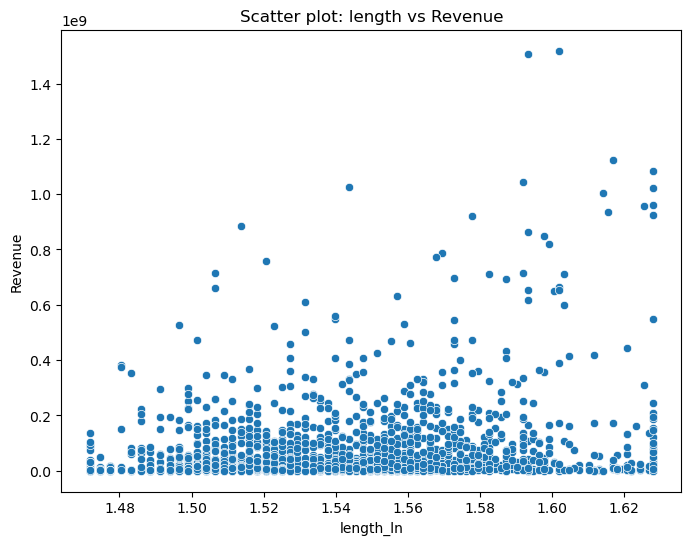

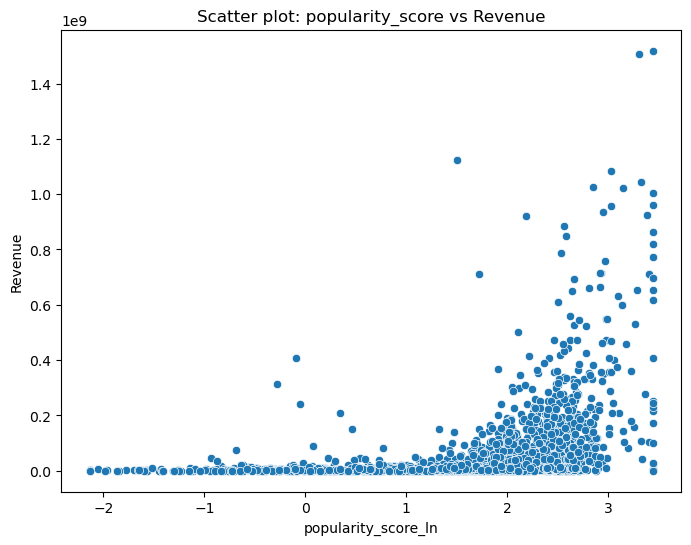

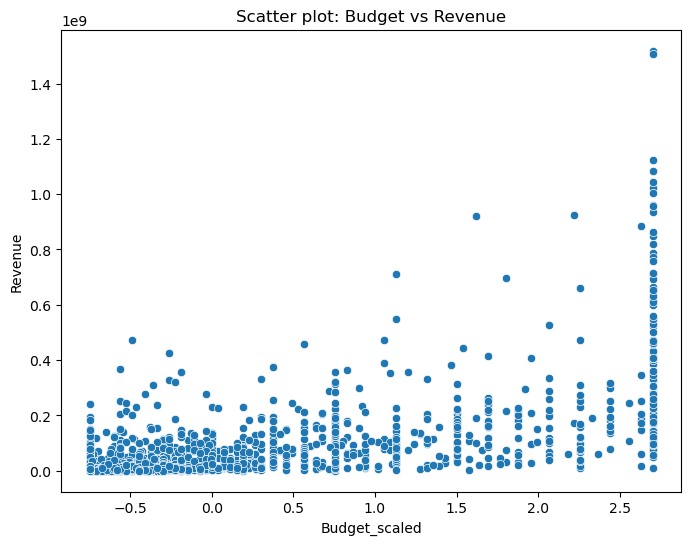

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


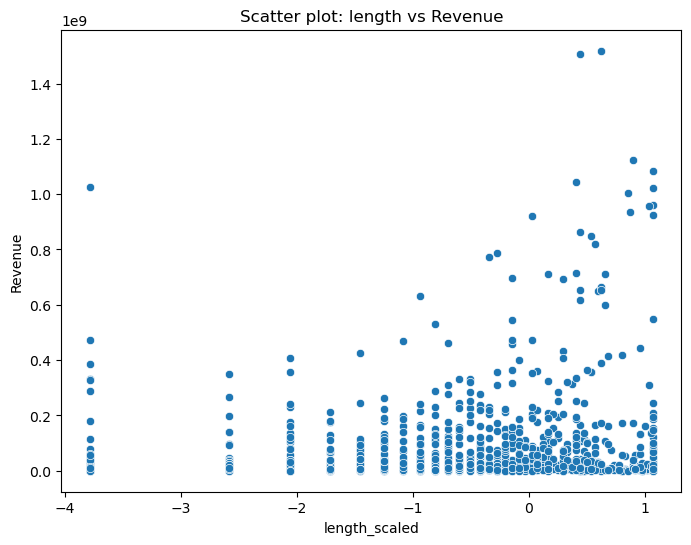

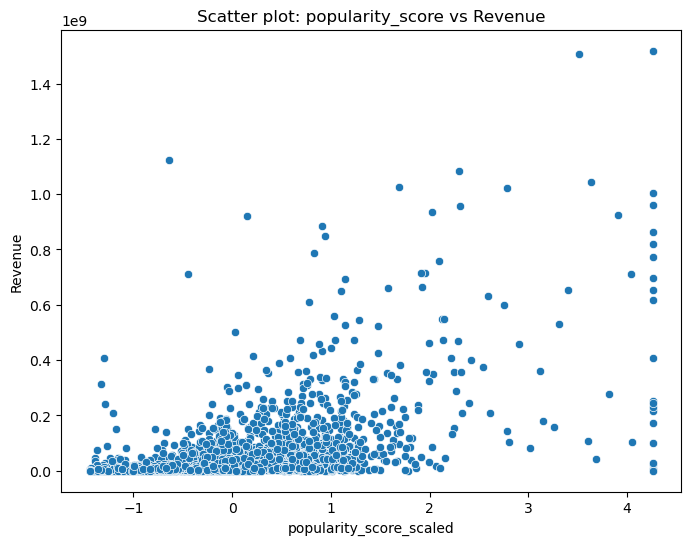

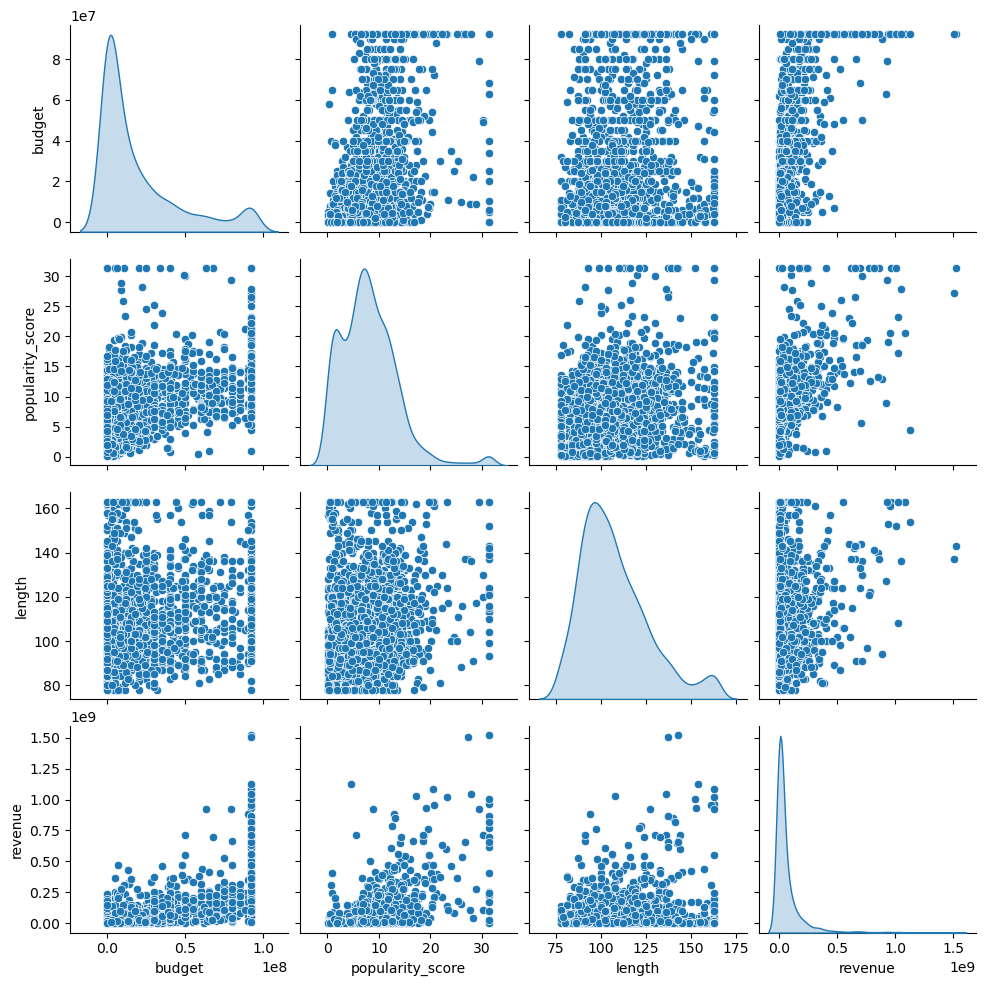

Pearson correlation:
                     budget  popularity_score    length   revenue
budget            1.000000          0.491354  0.255377  0.653280
popularity_score  0.491354          1.000000  0.197658  0.545447
length            0.255377          0.197658  1.000000  0.245548
revenue           0.653280          0.545447  0.245548  1.000000
Spearman correlation:
                     budget  popularity_score    length   revenue
budget            1.000000          0.525424  0.280155  0.707554
popularity_score  0.525424          1.000000  0.200554  0.606241
length            0.280155          0.200554  1.000000  0.267390
revenue           0.707554          0.606241  0.267390  1.000000


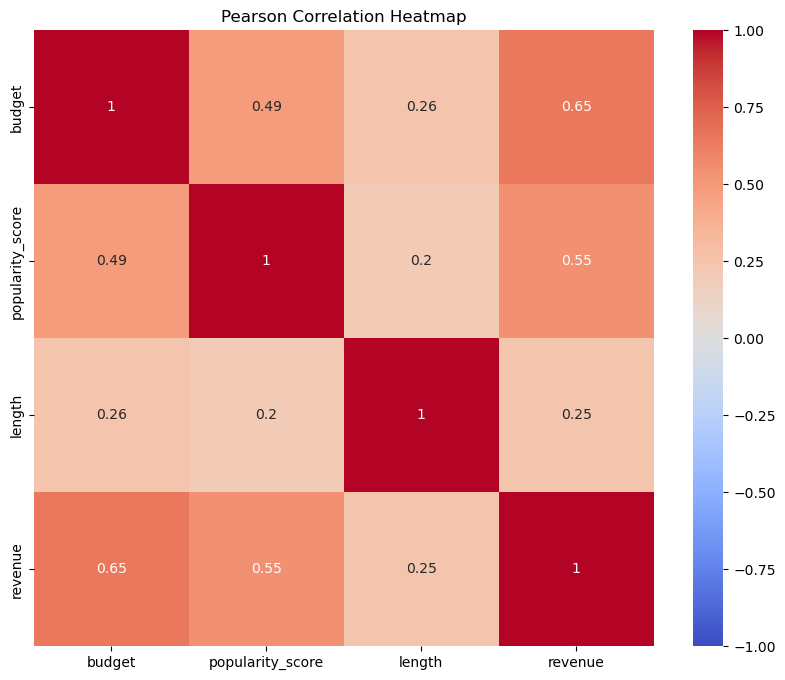

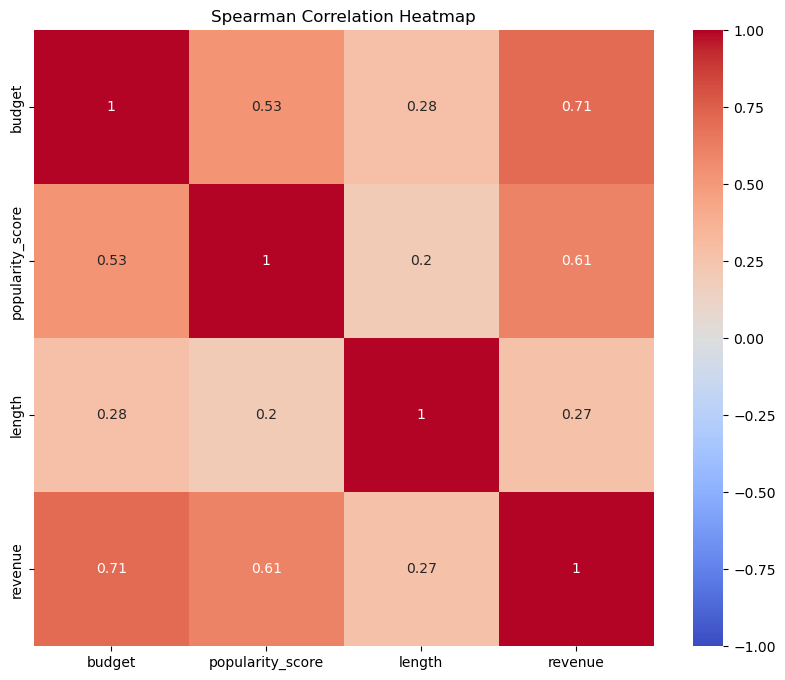

Number NAs
Budget:  0
Length:  0
Location NA length: 
 Empty DataFrame
Columns: [title, language, country, length, date, genre, summary, collection, company, webpage, poster_file, cast, keywords, crew, popularity_score, budget, length_wind, popularity_score_wind, length_2, length_3, length_ln, budget_2, budget_3, budget_ln, popularity_score_2, popularity_score_3, popularity_score_ln]
Index: []

[0 rows x 27 columns]
Popularity score:  0
Date:  0
Cast 18
Collection:  1598
Company:  102
Location NA comapny: 
                                                   title language country  \
15                             Harvard Beats Yale 29-29       en     NaN   
46                              Небо. Самолёт. Девушка.       ru      RU   
68                                       Crooked Arrows       en      US   
75                                              Kahaani       hi      IN   
88                                                 Meru       en      US   
...                            

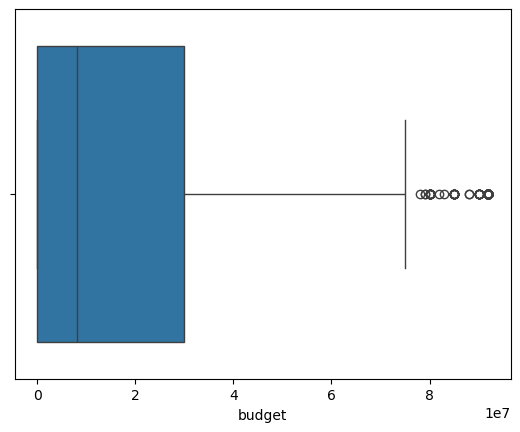

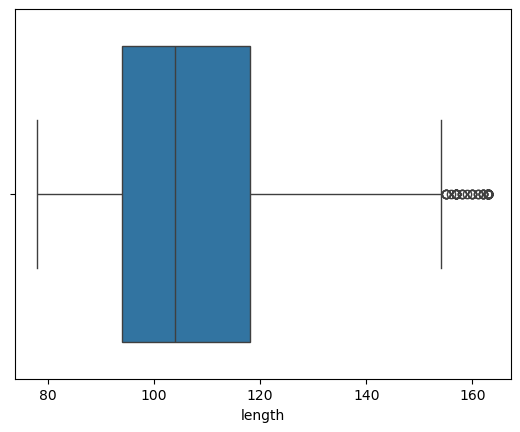

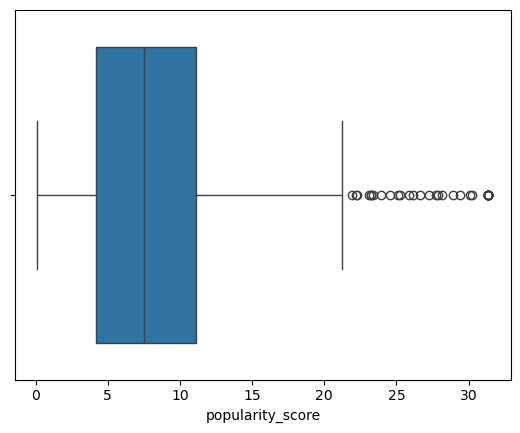

Outliers budget:                        title language   country  length      date  \
2              Tomorrowland       en        US   130.0   5/19/15   
31              John Carter       en        US   132.0    3/7/12   
51         Ocean's Thirteen       en        US   122.0    6/7/07   
65                      Pan       en        US   111.0   9/24/15   
81    Jack the Giant Slayer       en        US   114.0   2/27/13   
...                     ...      ...       ...     ...       ...   
1956  Ice Age: The Meltdown       en        US    91.0   3/23/06   
1961         Cinderella Man       en        US   144.0    6/2/05   
1964            San Andreas       en  CA,US,AU   114.0   5/27/15   
1990                  金陵十三釵       zh     CN,HK   145.0  12/15/11   
1998                Gravity       en     GB,US    91.0   9/27/13   

                                         genre  \
2     Adventure,Family,Mystery,Science Fiction   
31            Action,Adventure,Science Fiction   
51             

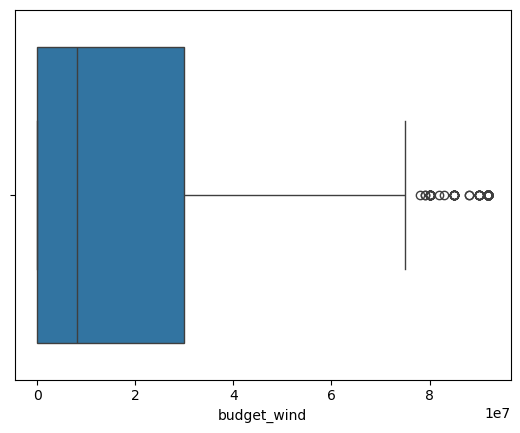

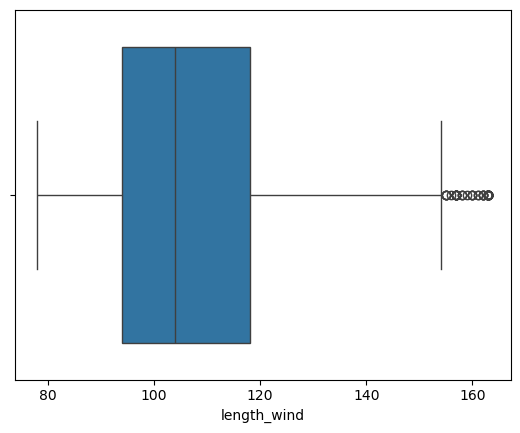

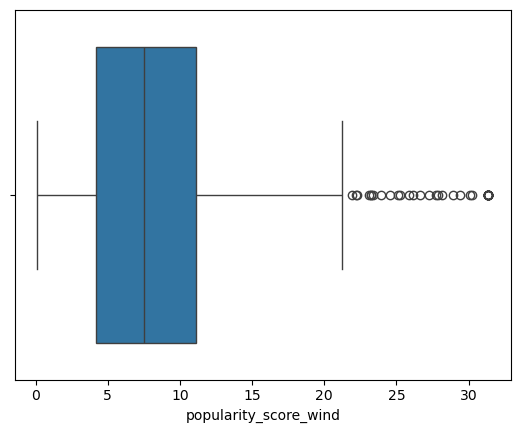

Outliers budget (Winsorized): 148
Outliers length (Wind):                      title language   country  length      date  \
19            హ్యాపీ డేస్       te        IN   160.0   9/28/07   
24          37°2 le matin       fr        FR   163.0    4/9/86   
38           Jodhaa Akbar       hi        IN   163.0   2/15/08   
50              Cleopatra       en  GB,US,CH   163.0   6/12/63   
77    Miracle at St. Anna       en     IT,US   160.0   9/15/08   
...                   ...      ...       ...     ...       ...   
1817     The Sand Pebbles       en        US   163.0  12/20/66   
1835               Carlos       en     FR,DE   163.0   5/19/10   
1849     Scent of a Woman       en        US   157.0  12/23/92   
1915     Laurence Anyways       fr     CA,FR   163.0   5/18/12   
1939              Hey Ram       ta        IN   163.0   2/18/00   

                                       genre  \
19                                     Drama   
24                             Drama,Romance   
38  

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Features polinómicas y log
df_train_in['length_2'] = df_train_in['length'] ** 2
df_train_in['length_3'] = df_train_in['length'] ** 3
df_train_in['length_ln'] = np.log(df_train_in['length'].replace(0, np.nan)).replace([-np.inf, np.inf], np.nan).fillna(-1)
df_train_in['budget_2'] = df_train_in['budget'] ** 2
df_train_in['budget_3'] = df_train_in['budget'] ** 3
df_train_in['budget_ln'] = np.log(df_train_in['budget'].replace(0, np.nan)).replace([-np.inf, np.inf], np.nan).fillna(-1)
df_train_in['popularity_score_2'] = df_train_in['popularity_score'] ** 2
df_train_in['popularity_score_3'] = df_train_in['popularity_score'] ** 3
df_train_in['popularity_score_ln'] = np.log(df_train_in['popularity_score'].replace(0, np.nan)).replace([-np.inf, np.inf], np.nan).fillna(-1)

#======================================================

# Scatter simple
#Budget - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_train_in["budget"], y=y_train["revenue"])
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.title("Scatter plot: Budget vs Revenue")
plt.show()
#Parece que hay correlacion positiva, confirmado por Spearman y Pearson
#(hay que ver con log)

#length - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=np.log(df_train_in["length"]), y=y_train["revenue"])
plt.xlabel("length")
plt.ylabel("Revenue")
plt.title("Scatter plot: length vs Revenue")
plt.show()
#Parece que no hay correlacion, muy baja ya sea con Pearson o Spearman

#popularity_score - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_train_in["popularity_score"], y=y_train["revenue"])
plt.xlabel("popularity_score")
plt.ylabel("Revenue")
plt.title("Scatter plot: popularity_score vs Revenue")
plt.show()
#Hay correlacion pero poco fuerte, hay que ver con log

# Scatter ^2
#Budget - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_train_in["budget_2"], y=y_train["revenue"])
plt.xlabel("Budget^2")
plt.ylabel("Revenue")
plt.title("Scatter plot: Budget vs Revenue")
plt.show()
#Parece que hay correlacion positiva, confirmado por Spearman y Pearson
#(hay que ver con log)

#length - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=np.log(df_train_in["length_2"]), y=y_train["revenue"])
plt.xlabel("length^2")
plt.ylabel("Revenue")
plt.title("Scatter plot: length vs Revenue")
plt.show()
#Parece que no hay correlacion, muy baja ya sea con Pearson o Spearman

#popularity_score - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_train_in["popularity_score_2"], y=y_train["revenue"])
plt.xlabel("popularity_score^2")
plt.ylabel("Revenue")
plt.title("Scatter plot: popularity_score vs Revenue")
plt.show()

# Scatter ^3
#Budget - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_train_in["budget_3"], y=y_train["revenue"])
plt.xlabel("Budget^3")
plt.ylabel("Revenue")
plt.title("Scatter plot: Budget vs Revenue")
plt.show()
#Parece que hay correlacion positiva, confirmado por Spearman y Pearson
#(hay que ver con log)

#length - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=np.log(df_train_in["length_3"]), y=y_train["revenue"])
plt.xlabel("length^3")
plt.ylabel("Revenue")
plt.title("Scatter plot: length vs Revenue")
plt.show()
#Parece que no hay correlacion, muy baja ya sea con Pearson o Spearman

#popularity_score - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_train_in["popularity_score_3"], y=y_train["revenue"])
plt.xlabel("popularity_score^3")
plt.ylabel("Revenue")
plt.title("Scatter plot: popularity_score vs Revenue")
plt.show()

# Scatter ^2
#Budget - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_train_in["budget_ln"], y=y_train["revenue"])
plt.xlabel("Budget_ln")
plt.ylabel("Revenue")
plt.title("Scatter plot: Budget vs Revenue")
plt.show()
#Parece que hay correlacion positiva, confirmado por Spearman y Pearson
#(hay que ver con log)

#length - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=np.log(df_train_in["length_ln"]), y=y_train["revenue"])
plt.xlabel("length_ln")
plt.ylabel("Revenue")
plt.title("Scatter plot: length vs Revenue")
plt.show()
#Parece que no hay correlacion, muy baja ya sea con Pearson o Spearman

#popularity_score - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_train_in["popularity_score_ln"], y=y_train["revenue"])
plt.xlabel("popularity_score_ln")
plt.ylabel("Revenue")
plt.title("Scatter plot: popularity_score vs Revenue")
plt.show()

#Ultima prueba para length con escala

# Columnas a centrar y reducir
cols_to_scale = ['length',
                 'budget',
                 'popularity_score']

df_train_scaled = df_train_in.copy()

for col in cols_to_scale:
    mean = df_train_scaled[col].mean()        # media
    std = df_train_scaled[col].std()          # desviación estándar
    df_train_scaled[col + '_scaled'] = (df_train_scaled[col] - mean) / std

# Scatter Escalado
#Budget - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_train_scaled["budget_scaled"], y=y_train["revenue"])
plt.xlabel("Budget_scaled")
plt.ylabel("Revenue")
plt.title("Scatter plot: Budget vs Revenue")
plt.show()
#Parece que hay correlacion positiva, confirmado por Spearman y Pearson
#(hay que ver con log)

#length - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=np.log(df_train_scaled["length_scaled"]), y=y_train["revenue"])
plt.xlabel("length_scaled")
plt.ylabel("Revenue")
plt.title("Scatter plot: length vs Revenue")
plt.show()
#Parece que no hay correlacion, muy baja ya sea con Pearson o Spearman

#popularity_score - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_train_scaled["popularity_score_scaled"], y=y_train["revenue"])
plt.xlabel("popularity_score_scaled")
plt.ylabel("Revenue")
plt.title("Scatter plot: popularity_score vs Revenue")
plt.show()

#======================================================

#Matriz dispersion
features = ["budget", "popularity_score", "length", "revenue"]
df_plot = df_train_in.copy()
df_plot["revenue"] = y_train.values.ravel()

sns.pairplot(df_plot[features], diag_kind="kde")
plt.show()

#Calcular Corr
df_plot = df_plot[features]
# Pearson
pearson_corr = df_plot.corr(method="pearson")
print("Pearson correlation:\n", pearson_corr)

# Spearman
spearman_corr = df_plot.corr(method="spearman")
print("Spearman correlation:\n", spearman_corr)

#Grafico corr
plt.figure(figsize=(10,8))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pearson Correlation Heatmap")
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Spearman Correlation Heatmap")
plt.show()


##======================================================
#NAs

print("Number NAs")
print("Budget: ",df_train_in['budget'].isna().sum())
print("Length: ",df_train_in['length'].isna().sum())
print("Location NA length: \n", df_train_in.loc[df_train_in['length'].isna()])
#Observation n# 481 Королёв in Russian
print("Popularity score: ",df_train_in['popularity_score'].isna().sum())
print("Date: ",df_train_in['date'].isna().sum())
print("Cast", df_train_in['cast'].isna().sum())
print("Collection: ", df_train_in['collection'].isna().sum())
#We can fairly suppose that if collection is NA then probably no collection (else drop it)
print("Company: ",df_train_in['company'].isna().sum())
print("Location NA comapny: \n", df_train_in.loc[df_train_in['company'].isna()])
#They are really NA War, Inc is from Universal for example but figures as NA
#Same with "The Good Doctor", it is from Magnolia Pictures
#Drop it? Majority class?
print("Webpage: ", df_train_in['webpage'].isna().sum())
#We can fairly suppose that if webpage is NA then probably no collection (else drop it)
print("Language: ",df_train_in['language'].isna().sum())
print("Country: ", df_train_in['country'].isna().sum())
#We didn't use this variable for yet

##======================================================

#Outliers
sns.boxplot(x=df_train_in['budget'])
plt.show()
sns.boxplot(x=df_train_in['length'])
plt.show()
sns.boxplot(x=df_train_in['popularity_score'])
plt.show()

#Identificarlos y contarlos
#Budget
Q1 = df_train_in['budget'].quantile(0.25)
Q3 = df_train_in['budget'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_budget = df_train_in[(df_train_in['budget'] < lower_bound) | (df_train_in['budget'] > upper_bound)]
print("Outliers budget: ",outliers_budget)
#Hay 148 (7.4% de los 2000, >5% problema)

#Length
Q1 = df_train_in['length'].quantile(0.25)
Q3 = df_train_in['length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_length = df_train_in[(df_train_in['length'] < lower_bound) | (df_train_in['length'] > upper_bound)]
print("Outliers length: ",outliers_length)
#Hay 83 (4.2% de los 2000 <5% entonces OK)$

#Popularity score
Q1 = df_train_in['popularity_score'].quantile(0.25)
Q3 = df_train_in['popularity_score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_popularity = df_train_in[(df_train_in['popularity_score'] < lower_bound) | (df_train_in['popularity_score'] > upper_bound)]
print("Outliers popularity score: ",outliers_popularity)
#Hay 43 (2.1% de los 2000 <5% entonces OK)

#Hacemos windsorization (sino podemos reemplazar por mean)
from scipy.stats.mstats import winsorize

df_train_in['budget_wind'] = np.array(winsorize(df_train_in['budget'], limits=[0.05, 0.05]))
df_train_in['length_wind'] = np.array(winsorize(df_train_in['length'], limits=[0.02, 0.02]))
df_train_in['popularity_score_wind'] = np.array(winsorize(df_train_in['popularity_score'], limits=[0.01, 0.01]))#Aplicamos margenes para llegar a 2% del total

#Chequeamos boxplot
sns.boxplot(x=df_train_in['budget_wind'])
plt.show()
sns.boxplot(x=df_train_in['length_wind'])
plt.show()
sns.boxplot(x=df_train_in['popularity_score_wind'])
plt.show()

#Chequeamos numero total
#Budget
Q1_w = np.percentile(df_train_in['budget_wind'], 25)
Q3_w = np.percentile(df_train_in['budget_wind'], 75)
IQR_w = Q3_w - Q1_w
lower_bound_w = Q1_w - 1.5*IQR_w
upper_bound_w = Q3_w + 1.5*IQR_w

outliers_budget_wind = df_train_in[(df_train_in['budget_wind'] < lower_bound_w) | (df_train_in['budget_wind'] > upper_bound_w)]
print("Outliers budget (Winsorized):", len(outliers_budget_wind))

#Length
Q1 = df_train_in['length_wind'].quantile(0.25)
Q3 = df_train_in['length_wind'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_length_wind = df_train_in[(df_train_in['length_wind'] < lower_bound) | (df_train_in['length_wind'] > upper_bound)]
print("Outliers length (Wind): ",outliers_length_wind)

#Popularity score
Q1 = df_train_in['popularity_score_wind'].quantile(0.25)
Q3 = df_train_in['popularity_score_wind'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_popularity_wind = df_train_in[(df_train_in['popularity_score_wind'] < lower_bound) | (df_train_in['popularity_score_wind'] > upper_bound)]
print("Outliers popularity score (Wind): ",outliers_popularity_wind)

In [39]:
# Filas donde popularity_score es negativa
neg_popularity = df_test[df_test['popularity_score'] < 0]

# Filas donde length es negativa
neg_length = df_test[df_test['length'] < 0]

# Filas donde cualquiera de las dos es negativa
neg_both = df_test[(df_test['popularity_score'] < 0) | (df_test['length'] < 0)]

# Mostrar algunos resultados
print("🔴 Valores negativos en popularity_score:")
print(neg_popularity.head())

print("\n🔴 Valores negativos en length:")
print(neg_length.head())

print("\n🔴 Filas con negativos en alguna de las dos:")
print(neg_both.head())


🔴 Valores negativos en popularity_score:
                    title language country    length      date  \
2001     Sharky's Machine       en      US  0.761795  12/18/81   
2002             Waterloo       en   IT,RU  1.078539  10/26/70   
2003           Love Story       en      US -0.452389  12/16/70   
2004  Operation Petticoat       en      US  0.867376   12/5/59   
2008             Downtown       en      US -0.610761   1/12/90   

                                 genre  \
2001       Crime,Drama,Action,Thriller   
2002              History,Action,Drama   
2003                     Drama,Romance   
2004             Action,Comedy,Romance   
2008  Action,Adventure,Comedy,Thriller   

                                                summary collection  \
2001  Sharky gets busted back to working vice, where...        NaN   
2002  After defeating France and imprisoning Napoleo...        NaN   
2003  Harvard Law student Oliver Barrett IV and musi...        NaN   
2004  A World War II submarin

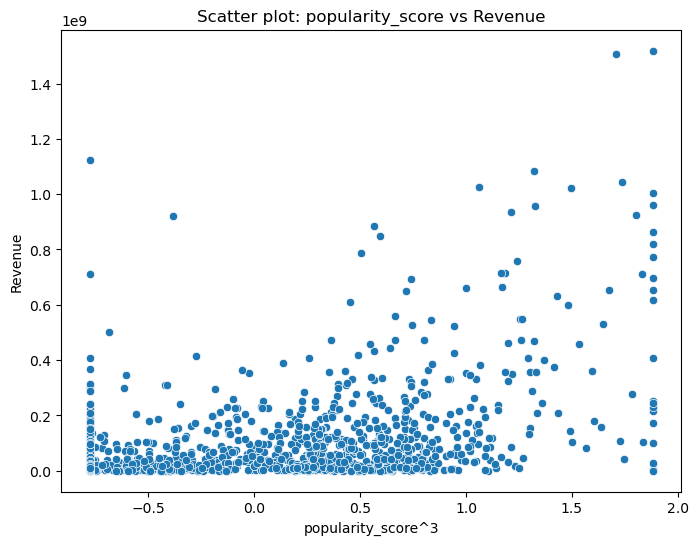

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#popularity_score - revenue
plt.figure(figsize=(8,6))
sns.scatterplot(x=np.log1p(df_train_in["popularity_score"]), y=y_train["revenue"])
plt.xlabel("popularity_score^3")
plt.ylabel("Revenue")
plt.title("Scatter plot: popularity_score vs Revenue")
plt.show()

In [49]:
"""
#Prueba 3
from sklearn.metrics import mean_squared_log_error
import numpy as np

xgb = XGBRegressor(
    n_estimators=100,         # ← CAMBIO: 50k → 1500 (30s vs 2h)
    learning_rate=0.1,        # ← CAMBIO: 0.0001 → 0.05 (Producto=75)
    max_depth=3,               # ← CAMBIO: 7 → 6 (más capacidad)
    random_state=42,    
    # ⭐ RÁPIDO + PRECISIÓN
    tree_method='hist',
    verbosity=0,
    objective='reg:squaredlogerror'
)

xgb.fit(X_tr, y_tr)

y_output = np.maximum(xgb.predict(X_val), 0)
msle_score = mean_squared_log_error(y_val, y_output)
print(f"MSLE DIRECTO: {msle_score:.6f}")
"""

NameError: name 'y_test' is not defined